In [47]:
import os
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

# Set paths
image_folder = '/kaggle/input/satelliteimages/data/images'
label_folder = '/kaggle/input/satelliteimages/data/labels'

# Load and preprocess data
def load_and_preprocess(image_file, label_file):
    image = imageio.imread(image_file)
    label = imageio.imread(label_file)
    
    # Normalize image
    image = image.astype(np.float32) / 255.0
    # Normalize label
    label = (label > 0).astype(np.float32)  # Ensure binary labels
    
    return image, label

# Load all images and labels
image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder)])
label_files = sorted([os.path.join(label_folder, f) for f in os.listdir(label_folder)])

images = []
labels = []
for img_file, lbl_file in zip(image_files, label_files):
    img, lbl = load_and_preprocess(img_file, lbl_file)
    images.append(img)
    labels.append(lbl)

images = np.array(images)
labels = np.array(labels)

# Expand label dimensions for binary classification
labels = np.expand_dims(labels, axis=-1)

# Check shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Images shape: (306, 128, 128, 12)
Labels shape: (306, 128, 128, 1)


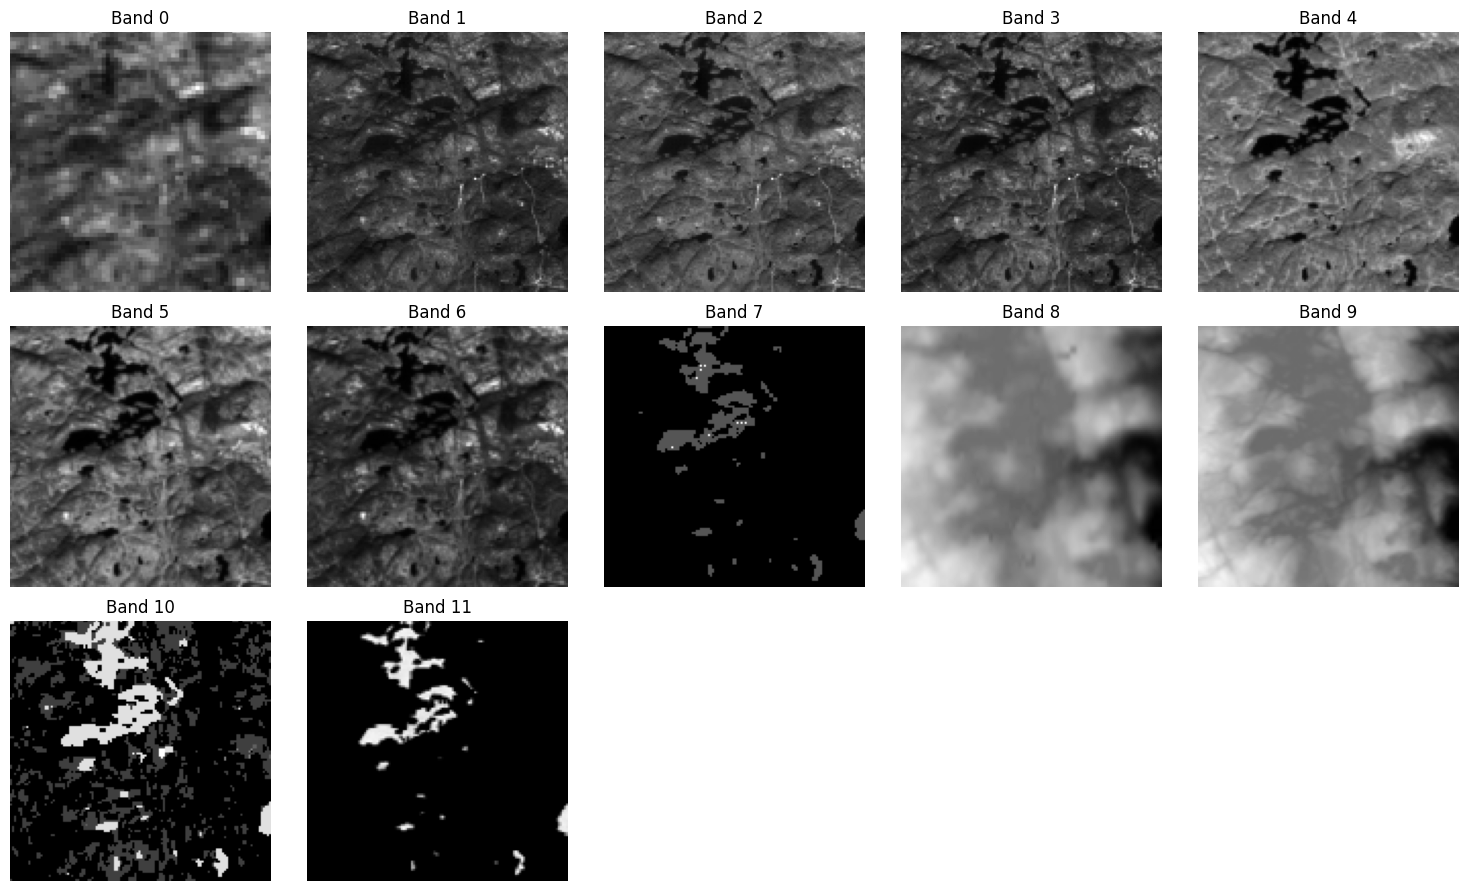

In [48]:
# Visualization: Show bands of a sample image
def visualize_bands(image, bands_per_row=5):
    num_bands = image.shape[2]
    num_rows = int(np.ceil(num_bands / bands_per_row))
    
    fig, axes = plt.subplots(num_rows, bands_per_row, figsize=(15, num_rows * 3))
    for i in range(num_bands):
        row = i // bands_per_row
        col = i % bands_per_row
        ax = axes[row, col]
        ax.imshow(image[:, :, i], cmap='gray')
        ax.set_title(f'Band {i}')
        ax.axis('off')
    
    for i in range(num_bands, num_rows * bands_per_row):
        row = i // bands_per_row
        col = i % bands_per_row
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize bands of the first sample image
sample_image = images[0]
visualize_bands(sample_image, bands_per_row=5)


In [49]:
# Define U-Net model
def unet_model(input_size=(128, 128, 12)):
    inputs = layers.Input(input_size)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    
    # Decoder
    up4 = layers.UpSampling2D(size=(2, 2))(conv3)
    up4 = layers.Concatenate()([up4, conv2])
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)
    
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.Concatenate()([up5, conv1])
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)
    
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize and compile the model
model = unet_model()
model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_165 (Conv2D) │ (None, 128, 128,  │      6,976 │ input_layer_15[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_166 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_165[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 64, 64,    │          0 │ conv2d_166[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_167 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_30… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_168 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_167[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 32, 32,    │          0 │ conv2d_168[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_169 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_31… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_170 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_169[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_30    │ (None, 64, 64,    │          0 │ conv2d_170[0][0]  │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_30      │ (None, 64, 64,    │          0 │ up_sampling2d_30… │
│ (Concatenate)       │ 384)              │            │ conv2d_168[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_171 (Conv2D) │ (None, 64, 64,    │    442,496 │ concatenate_30[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_172 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_171[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_31    │ (None, 128, 128,  │          0 │ conv2d_172[0][0]  │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_31      │ (None, 128, 128,  │          0 │ up_sampling2d_31… │
│ (Concatenate)       │ 192)              │            │ conv2d_166[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_173 (Conv2D) │ (None, 128, 128,  │    110,656 │ concatenate_31[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_174 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_173[0][0]

 Total params: 1,888,321 (7.20 MB)

 Trainable params: 1,888,321 (7.20 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=25,
                    batch_size=8,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 0.6250 - loss: 0.7631 - val_accuracy: 0.6278 - val_loss: 0.7753 - learning_rate: 0.0010
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7289 - loss: 0.5979 - val_accuracy: 0.6278 - val_loss: 0.6740 - learning_rate: 0.0010
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6975 - loss: 0.6179 - val_accuracy: 0.6278 - val_loss: 0.6675 - learning_rate: 0.0010
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6858 - loss: 0.6386 - val_accuracy: 0.6278 - val_loss: 0.6680 - learning_rate: 0.0010
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6963 - loss: 0.6212 - val_accuracy: 0.6278 - val_loss: 0.6713 - learning_rate: 0.0010
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7049 - loss: 0.6169 - val_accuracy: 0.6278 - val_loss: 0.6695 - learning_rate: 0.0010
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7153 - loss: 0.6093 - val_ac

In [51]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step - accuracy: 0.6143 - loss: 0.6683
Test Loss: 0.6623782515525818
Test Accuracy: 0.6277751326560974


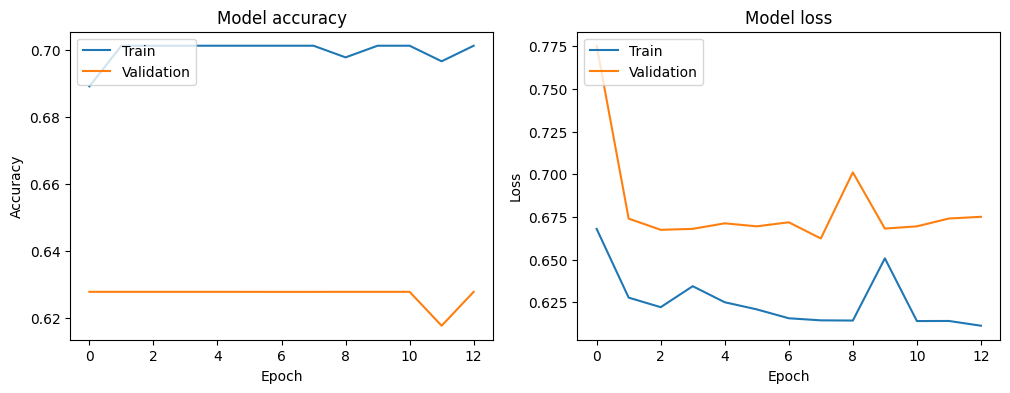

In [52]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

# Plot training history
plot_history(history)
